In [198]:
%pip install instructor
%pip install langgraph-checkpoint-sqlite
# %pip install -U langgraph
# %pip install "python-lsp-server[yapf]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: langgraph-sdk
    Found existing installation: langgraph-sdk 0.1.36
    Uninstalling langgraph-sdk-0.1.36:
      Successfully uninstalled langgraph-sdk-0.1.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.18
    Uninstalling langchain-core-0.3.18:
      Successfully uninstalled langchain-core-0.3.18
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.48
    Uninstalling langgraph-0.2.48:
      Successfully uninstalled langgraph-0.2.48
Note: you may need to restart the kernel to use updated packages.


# The Agentic Blog Writer

> A study to create agentic process for writing blogs on given topics. The solution should include few agents organised in a graph. The input should be the topic to research

## Agent Definitions

The agents that would formulate the graph are the following:

- Topics Writer
    - It will take in company specifics - previous articles and usps
    - It will analyse the industry which the company belongs to
    - It will take in a target for the company, e.g.
      - increase company popularity (awareness)
      - promote company services
      - find technology trends that relate to the company's industry
    - It will produce 3 directions to research
- Researcher(s)
  - For each of the topics span a researcher
  - Researches would take in the topic and rationale
  - They will produce search prompts
  - They will take in questions by the copywriter to produce additional prompts until a total of search iterations
  - The output should be a writing plan for a blog post on the topic


In [1]:
from typing import List
from typing_extensions import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from ollama import Client

from IPython.display import Image, Markdown, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages.utils import get_buffer_string

import concurrent.futures

from langgraph.constants import Send

import operator, os, json, random, re
os.environ['USER_AGENT'] = 'Mozilla/5.0 (platform; rv:gecko-version) Gecko/gecko-trail Firefox/firefox-version'
from langchain_community.document_loaders import WebBaseLoader, SeleniumURLLoader
import instructor
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

#### Helpers

Some utility functions that are used below:


In [3]:
client = Client(
      host='ollama',
    )
client.list()

{'models': [{'name': 'deepseek-r1:32b',
   'model': 'deepseek-r1:32b',
   'modified_at': '2025-02-03T07:45:31.124246491Z',
   'size': 19851337640,
   'digest': '38056bbcbb2d068501ecb2d5ea9cea9dd4847465f1ab88c4d4a412a9f7792717',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '32.8B',
    'quantization_level': 'Q4_K_M'}},
  {'name': 'qwen2.5-coder:32b',
   'model': 'qwen2.5-coder:32b',
   'modified_at': '2025-01-26T14:18:39.353482286Z',
   'size': 19851349856,
   'digest': '4bd6cbf2d094264457a17aab6bd6acd1ed7a72fb8f8be3cfb193f63c78dd56df',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '32.8B',
    'quantization_level': 'Q4_K_M'}},
  {'name': 'llama3.1:8b-instruct-fp16',
   'model': 'llama3.1:8b-instruct-fp16',
   'modified_at': '2024-11-20T15:44:02.680559362Z',
   'size': 16068910253,
   'digest': '4aacac4194543ff7f70dab3f2eb

In [2]:
def find_article_data(md: TypedDict, all_articles: List) -> TypedDict:
    return next(({"title": selected["id"], 
                  "content": md["content"],
                  "short_copy": selected["shortCopy"],
                  "date": selected["date"]
                } for selected in all_articles if selected["id"] == md["id"]), None)

def company_context_builder(blog_articles_src: str, articles_meta_src: str, usps_src: str):
    files = os.listdir(blog_articles_src)
    arr_of_md = []
    for file in files:
        if ".md" in file:
            with open(blog_articles_src + file, 'r', encoding="utf-8-sig") as md:
                arr_of_md.append({"id": file.split('.')[0], "content": md.read()})
    with open(articles_meta_src, 'r') as articles_json:
        loaded = json.load(articles_json)
        articles = loaded.get("articles", [])
    
    combined = [find_article_data(md, articles) for md in arr_of_md if find_article_data(md, articles) != None]

    usp_files = os.listdir(usps_src)

    usps = []
    for usp_file in usp_files:
        if ".md" in usp_file:
            with open(usps_src + usp_file, 'r', encoding="utf-8-sig") as usp:
                usps.append(usp.read())
    
        
    return (combined, usps)

### The Topics Writer

#### Data Structures:

In [3]:
class Topic(BaseModel):
    title: str = Field(
        description="Proposed title for a blog post.",
    )
    rationale: str = Field(
        description="The rationale why this topic title has been chosen."
    )
class TopicSelection(BaseModel):
    topics: List[Topic]

class CompanyProfile(BaseModel):
    name: str = Field(description="Company name")
    description: str = Field(description="Company description")

class Article(BaseModel):
    title: str = Field(description="Blog article title")
    content: str = Field(description="Blog article content in markdown")
    short_copy: str = Field(description="Article summary and essence")
    date: str = Field(description="Article publish date")

    

#### The Graph State

In [4]:
class TopicAnalyserState(TypedDict):
    goal: str
    company_profile: CompanyProfile
    previous_articles: List[Article]
    usps: List[str]
    max_questions: int
    topics: List[Topic]



In [5]:
def generate_research_direction_prompt() -> str:
    
    return f"""
        You are a senior marketing executive. Your job is to understand marketing trends and propose topics for blog posts.
        Your copywriting collegue will have a goal to achieve. You are to analyse this goal and based on the company profile
        suggest a blog post direction for further research. Please only answer the questions posed by your human copywriter.
    """

def generate_research_user_prompt(company_articles: List[Article], company_usps: List[str], company_profile: CompanyProfile, goal):
    titles = "".join([f"{' '.join(article['title'].split('_'))}\n\n========================\n\n" for article in company_articles])
    usps = "".join([f"{usp}\n\n=====================\n\n" for usp in company_usps])
    return f"""
    {goal}
    
    Here is relevant data to take in consideration.
     
    Company name: {company_profile["name"]}
        
    Short description: {company_profile["description"]}
    
    Previous example articles titles: 
    
    {titles}
    
    Company USPs in markdown: 
    
    {usps}
    """

    examples = """
    Examples of good directions would be:

    >> Create content on the following topic: Digital trends in 2025 for display advertising. I propose this direction to research because...

    >> Create new blog post or case study outlining the phasing out of 3rd party cookies by Google. I propose this direction to research because...
    """

In [9]:
c, u = company_context_builder("./data/streameye_context_data/articles/", 
                            './data/streameye_context_data/articles/articles.json',
                            './data/streameye_context_data/usps/')

In [5]:
type(c)

list

In [47]:
company_profile = {
    "name": "StreamEye LTD",
    "description": """
        Streameye is the creative management platform for fast-moving brands that allows you 
        to mass-produce creatives in a manner of minutes.
    """
}
goal = """
Having in mind the company data supplied below, suggest 3 different titles for new blog posts that would help me increase Streameye's awareness across CMOs of
betting companies. Below each title please explain your rationale for selecting it!
"""
system = generate_research_direction_prompt()
user = generate_research_user_prompt(c, u, company_profile, goal)

NameError: name 'c' is not defined

In [89]:
llm = ChatOllama(
    model="llama3.1:8b-instruct-fp16",
    temperature=0.05,
    num_ctx=16000,
    base_url="ollama",
)

In [9]:
structured_llm = llm.with_structured_output(schema=TopicSelection)

In [24]:
# r = structured_llm.invoke([SystemMessage(system), HumanMessage(user)])
instructed_r = llm.chat.completions.create(
    model="llama3.1:8b-instruct-fp16",
    messages=[{"role": "system", "content": system}, {"role": "user", "content": user}],
    response_model=TopicSelection)

In [6]:
def generate_topic_ideas(state: TopicAnalyserState):

    required_keys = {
        "goal": "Goal",
        "company_profile": "Company Profile",
        "usps": "USPs",
        "previous_articles": "Previous Articles"
    }
    
    missing_keys = [name for key, name in required_keys.items() if not state.get(key)]
    if missing_keys:
        raise ValueError(f"Missing required fields: {', '.join(missing_keys)}")
    
    goal = state["goal"]
    company_profile = state["company_profile"]
    usps = state["usps"]
    previous_articles = state["previous_articles"]

    topic_goal = f"""Having in mind the company data supplied below, suggest 2 titles for blog posts that would help me {goal}.
    Below the title please explain your rationale for selecting it! When suggesting titles, make them sound intriguing and avoid
    direct sales pitches.
    """
    system = generate_research_direction_prompt()
    user = generate_research_user_prompt(company_articles=previous_articles, 
                                         company_profile=company_profile,
                                         company_usps=usps,
                                         goal=topic_goal
                                        )

    llm = instructor.from_openai(OpenAI(
            base_url="http://ollama:11434/v1",
            api_key="ollama",  # required, but unused
        ),
        mode=instructor.Mode.JSON,
        temperature=0.05, top_p=0.8
    )

    instructed_r = llm.chat.completions.create(
        model="llama3.1:8b-instruct-fp16",
        messages=[{"role": "system", "content": system}, {"role": "user", "content": user}],
        response_model=TopicSelection
    )
    return {"topics": instructed_r.topics}
    

Sending it to Researcher for all topics:

In [7]:
def initiate_all_researchers(state: TopicAnalyserState): 

    """ node that distributes topics to researcher subgraphs """
    
    topics = state.get("topics", [])
    max_questions = state.get("max_questions", 2)
    goal = state.get("goal", None)
    
    if len(topics) == 0:
        raise ValueError("Error fetching topics from state")

    if not goal:
        raise ValueError("You have not set a research goal. Try again")

    return [Send("perform_research", {"topic": topic, 
                                      "messages": [HumanMessage(f"So you are writing about {topic.title}")], 
                                      "max_questions": max_questions, 
                                      "goal": goal
                                     }) for topic in topics]

In [25]:
print(instructed_r)

topics=[Topic(title='5 Ways Betting Companies Can Boost Brand Consistency Across Ad Campaigns', rationale="This title is chosen because it directly addresses the pain point of CMOs in betting companies who struggle to maintain brand consistency across different ad campaigns. Streameye's USP 'Own Your Brand' can be highlighted as a solution to this problem, showcasing how our platform helps brands stay on-brand and maintain creative control."), Topic(title='The Future of Ad Production: How Automation Can Revolutionize Betting Company Marketing', rationale="This title is chosen because it taps into the current trend of automation in marketing. Streameye's USP 'Creative Assets Production' can be highlighted as a solution that helps betting companies save time and costs by making ad creation easy and efficient, showcasing our platform's ability to automate creative production."), Topic(title='Streamlining Ad Production for Betting Companies: The Benefits of an Adaptive Platform', rationale

#### Building the Analyser

In [8]:
builder_analyser = StateGraph(TopicAnalyserState)

builder_analyser.add_node("generate_topic_ideas", generate_topic_ideas)

builder_analyser.add_edge(START, "generate_topic_ideas")
builder_analyser.add_edge("generate_topic_ideas", END)


# memory = MemorySaver()
# graph_analyser = builder_analyser.compile(checkpointer=memory)
# display(Image(graph_analyser.get_graph().draw_mermaid_png()))

In [9]:
articles, usps = company_context_builder("./data/streameye_context_data/articles/", 
                            './data/streameye_context_data/articles/articles.json',
                            './data/streameye_context_data/usps/')
company_profile = {
    "name": "StreamEye LTD",
    "description": """
        Streameye is the creative management platform for fast-moving brands that allows you 
        to mass-produce creatives in a manner of minutes.
    """
}
goal = """increase Streameye's awareness across CMOs of betting companies."""
thread = {"configurable": {"thread_id": 230}}

In [10]:
result = graph.invoke({"goal": goal, "previous_articles": articles, "usps": usps, "company_profile": company_profile, "max_questions": 3}, config=thread)

In [11]:
print(result["topics"])

[Topic(title='How Betting Companies Can Streamline Their Ad Production Process', rationale="This title is chosen because it directly addresses the pain points of betting companies, which is often struggling with ad production. By highlighting Streameye's ability to streamline this process, we can attract CMOs who are looking for solutions to improve their efficiency."), Topic(title='The Importance of Brand Consistency in Betting Advertising', rationale="This title is chosen because it speaks directly to the 'Own Your Brand' USP of Streameye. By emphasizing the importance of brand consistency, we can attract CMOs who are looking for ways to maintain their brand identity across different advertising channels."), Topic(title='Revolutionizing Betting Ad Campaigns with Automated Creative Assets Production', rationale="This title is chosen because it highlights Streameye's ability to automate creative assets production, which is a key benefit of the platform. By using words like 'revolutioni

### The Researcher

The researcher should take in suggested topics, together with communication with the copywriter and provide search results to complement existing knowledge on the topic.

It will be split into few nodes and will also take in maximum recurrence in search attempts.

- Produce Search Prompts
- Review search and ask questions
- Continue until max search reached
- Create an article plan as a result, together with resource URLs

#### Data Structures

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

class Report(BaseModel):
    conversaion: str = Field(description="The conversation between copywriter and expert as a string with concatenated sources")
    context: str = Field(description="The returned search documents used to generate the conversation")
    report_plan: str = Field(description="A plan of key points for writing the final report")
    title: str = Field(description="The title of the blog post")
    rationale: str = Field(description="Rationale about writing blog post with this title")


class ResearcherStateInput(TypedDict):
    topic: Topic
    goal: str
    messages: List
    max_questions: int

class ResearcherStateOutput(TypedDict):
    reports: List[Report]

class ResearcherState(MessagesState):
    topic: Topic
    goal: str
    max_questions: int
    search_query: str
    researcher_question: str
    expert_answer: str
    search_results: Annotated[List[str], operator.add]
    report: Annotated[List[Report], operator.add]

class SearchQuery(BaseModel):
    query: str = Field(description="Well formatted search query", 
                       examples=["pain points of betting providers when delivering ads",
                                "top CMPs to mitigate scarce design resource"])

llm = ChatOllama(
    model="llama3.1:8b-instruct-fp16",
    temperature=0.05,
    num_ctx=12000,
    base_url="ollama",
)
instructed_llm = instructor.from_openai(OpenAI(
        base_url="http://ollama:11434/v1",
        api_key="ollama",  # required, but unused
    ),
    mode=instructor.Mode.JSON,
    temperature=0.05
)

open_ai_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.05,
    max_tokens=16384,
    timeout=None,
    max_retries=1
)

tavily_search = TavilySearchResults(max_results=3)

In [10]:
open_ai_llm_mini = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.05,
    max_tokens=16384,
    timeout=None,
    max_retries=1
)
llm_small = ChatOllama(
    model="llama3.2",
    temperature=0.05,
    num_ctx=12000,
    base_url="ollama",
)

#### The Graph State

In [11]:
def gen_copywrite_question_system_prompt(topic: Topic, goal: str) -> str:

    return f"""
    You are a copywriter that needs to write about a topic in order to achieve set goals by your chief marketing officer. Your name is Suzan and 
    you have a great researcher colleague who is an expert in the field and will help you by answering your questions. Conduct a conversation 
    with your colleague to obtain more information on the topic.
    
    Here is the topic you need to write about:

    Topic: {topic.title}
    Here is a rationale why you need to write about it:
    {topic.rationale}

    Here is your ultimate goal set by your boss: {goal}
    
    Start by introducing yourself and continue to ask questions to drill down and refine your understanding of the topic.
            
    Remember to stay in character throughout your response, reflecting your professional occupation as the company copywriter 
    and goals provided to you. 
    """
def generate_question(state: ResearcherState):

    """ Node to generate a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    goal = state["goal"]
    # Generate question 
    system_prompt = gen_copywrite_question_system_prompt(topic=topic, goal=goal)
    
    question = llm.invoke([SystemMessage(system_prompt)] + messages + [HumanMessage("Ask another question as the company copywriter. If you are satisfied with the answers above, say: 'Thanks so much for your time'.")])
                          
        
    # lets disguise this as a human message?
    return {"messages": [HumanMessage(question.content)]}

def gen_expert_answer_system_prompt(goal: str, topic: Topic, context: str ) -> str: 
    return f"""
    You are a distinguished expert in online marketing. You are here to help your copywriter colleague by answering their questions by
    analysing supplied context from web search. When answering the questions always adhere to the following rules:

    1. Aim to help your colleague write a blog about this topic: {topic.title}
    2. Be aware that the goal of your marketing team is to: {goal}
    3. ONLY use the supplied context when answering the questions in the conversation. You should not delve into nor elaborate on any unverified knowledge 
    outside the scope of the context.
    4. Provide the sources from the context in the following way:
        - Include these sources as URLs in your answer next to any relevant statements. For example, for source # 1 use [1]
        - List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        - If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: [1] assistant/docs/llama3_1.pdf, page 7 
        - Skip the addition of the brackets as well as the Document source preamble in your citation
    
    Here is the context:
    {context}
    
    """


def generate_expert_answer(state: ResearcherState):

    """ The expert answer based on context and last question """

    messages = state["messages"]
    context = state["search_results"]
    goal = state["goal"]
    topic = state["topic"]

    system_message = gen_expert_answer_system_prompt(goal=goal, topic=topic, context=context)

    answer = llm.invoke([SystemMessage(system_message)] + messages)
    # Name the message as coming from the expert
    answer.name = "expert"
    
    return {"messages": [answer]}

In [12]:
def gen_search_prompt_system(topic: Topic) -> str:
    return f"""
    You are a brilliant assistant who specialises in web search. You will help your colleagues in generating well structured search query that 
    should return optimal search results. You will take into consideration the topic to research and any additional questions by your fellow human

    Topic to search for:
    {topic.title}

    Remember:
    1. Only provide one well structured web search prompt to help research the topic and the copywriter's questions.
    2. Do not answer the question yourself. 
    3. Do not provide a list of queries - just one.
    """

def generate_search_query(state: ResearcherState) -> str:

    messages = state.get("messages", [])
    topic = state.get("topic", None)

    if topic and len(messages) > 0:
        
        system = gen_search_prompt_system(topic)
        user = messages[-1].content
        structured_llm = llm.with_structured_output(SearchQuery)
        result = structured_llm.invoke([SystemMessage(system), HumanMessage(user)])
        return {"search_query": result.query}
    else:
        raise ValueError(f"Missing topic or previous messages")
        
    

In [13]:
def search_with_tavily(state: ResearcherState):
    
    """ Retrieve docs from Tavily """

    # Search
    search_docs = tavily_search.invoke(state["search_query"])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"search_results": [formatted_search_docs]} 

In [14]:
def conditional_ask_another_question(state: ResearcherState) -> Literal["generate_question", "report_writer"]:
     
    """ Route between asking more questions or writing up the blog plan """
    
    messages = state["messages"]
    max_questions = state.get('max_questions',2)

    num_questions = len([msg for msg in messages if isinstance(msg, AIMessage) and msg.name == "expert"])

    if num_questions < max_questions:
        return "generate_question"
    else:
        return "report_writer"

In [15]:
def gen_report_writer_user_prompt(topic: Topic, goal: str, conversation: str) -> str:
    return f"""
    Write the conspect for a corporate blog post for our company with title: 
    {topic.title}
    
    Here is a rationale why this blog post would contribute towards our marketing goal:
    
    Rationale:
    {topic.rationale}

    Goal:
    {goal}

    Here is the conversation between our copywriter and a marketing expert:
    {conversation}
    """

def report_writer(state: ResearcherState):

    """ Write a report on the potential blog post based on research """

    topic = state["topic"]
    goal = state["goal"]
    context = state["search_results"]

    conversation = get_buffer_string(state["messages"])

    system = """
    You are the senior copywriter who's task is to write a conspect/ digest on a blog post. 
    
    The conspect should contain the essence of a conversation between your colleague and an expert answering her questions. 
    
    Produce a paragraph summary of the conversation as well as a plan for the blog post as bullet points.
    When creating the plan, emphasize more on knowledge base obtained in the conversation rather than direct sales pitch
    for the company. 
    
    Remember, we need to achieve the goal set, but noone likes a direct sales pitch.
    
    We need the article to be informative with subtle mentions of the company as a process enabler and solver
    of any pain points that may have surfaced.
    
    Stick to maximum of 10 bullet points to outline how the blog article will achieve its goal.
    """

    user = gen_report_writer_user_prompt(topic=topic, goal=goal, conversation=conversation)

    report = llm.invoke([SystemMessage(system), HumanMessage(user)])
    print("report generated")
    return {"reports": 
            [{
                "report_plan": report.content,
                "context": context,
                "conversation": conversation,
                "title": topic.title,
                "rationale": topic.rationale
            }]
           }

    

In [16]:
builder_research = StateGraph(ResearcherState, input=ResearcherStateInput, output=ResearcherStateOutput)

builder_research.add_node("generate_question", generate_question)
builder_research.add_node("generate_search_query", generate_search_query)
builder_research.add_node("search_with_tavily", search_with_tavily)
builder_research.add_node("generate_expert_answer", generate_expert_answer)
builder_research.add_node("report_writer", report_writer)

builder_research.add_edge(START, "generate_question")
builder_research.add_edge("generate_question", "generate_search_query")
builder_research.add_edge("generate_search_query", "search_with_tavily")
builder_research.add_edge("search_with_tavily", "generate_expert_answer")
builder_research.add_conditional_edges("generate_expert_answer", conditional_ask_another_question, ["generate_question", "report_writer"])
builder_research.add_edge("report_writer", END)


# memory = MemorySaver()
# graph_research = builder_research.compile(checkpointer=memory)
# display(Image(graph_research.get_graph().draw_mermaid_png()))

In [ ]:
result["topics"][0]

In [20]:
## Testing it
graph_state = graph.get_state(config=thread)
goal = graph_state.values["goal"]
print(goal)
thread_research = {"configurable": {"thread_id": 704}}


NameError: name 'graph' is not defined

In [54]:
result_reasearch = graph_research.invoke({"topic": result["topics"][0], 
                                          "goal": goal, 
                                          "messages": [HumanMessage(f"So you are writing about {result["topics"][0].title}?")] }, config=thread_research)

QUESTION content="I'm Suzan, a copywriter at Streameye, and I'm excited to dive into this topic. I've been tasked with creating content that showcases our company's ability to help betting companies streamline their ad production process.\n\nTo get started, can you tell me a bit about the current pain points that betting companies face when it comes to ad production? What are some of the common challenges they encounter?\n\nAlso, what is the typical workflow like for a betting company when producing ads? Do they have in-house teams handling everything from concept to delivery, or do they outsource certain aspects of the process?" additional_kwargs={} response_metadata={'model': 'llama3.1:8b-instruct-fp16', 'created_at': '2025-02-12T10:03:52.144052312Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 5057950253, 'load_duration': 1886631505, 'prompt_eval_count': 303, 'prompt_eval_duration': 86000000, 'eval_count': 123, 'eval_durati

In [68]:
gr = graph_research.get_state(config=thread_research)
gr.values.get('search_query')

NameError: name 'graph_research' is not defined

In [56]:
result_reasearch

{'messages': [HumanMessage(content='So you are writing about How Betting Companies Can Streamline Their Ad Production Process?', additional_kwargs={}, response_metadata={}, id='e420e840-b603-4cee-b9f9-ce731f24347d'),
  HumanMessage(content="I'm Suzan, a copywriter at Streameye, and I'm excited to dive into this topic. I've been tasked with creating content that showcases our company's ability to help betting companies streamline their ad production process.\n\nTo get started, can you tell me a bit about the current pain points that betting companies face when it comes to ad production? What are some of the common challenges they encounter?\n\nAlso, what is the typical workflow like for a betting company when producing ads? Do they have in-house teams handling everything from concept to delivery, or do they outsource certain aspects of the process?", additional_kwargs={}, response_metadata={}, id='e055f5b0-c1ed-4517-a38a-11ca41e53fe0'),
  AIMessage(content="Suzan! It's great to help you

## The Big Graph

Here is the definition of the final graph. This is still incomplete, but will put the Topic creation and Research together for testing.

### State

In [50]:
class BlogWriter(TypedDict):
    goal: str
    company_profile: CompanyProfile
    previous_articles: List[Article]
    usps: List[str]
    max_questions: int
    topics: List[Topic]
    reports: Annotated[List[Report], operator.add]
    selected_report: Report
    final_documents: str
    human_article_feedback: Literal[str, 'AI', 'END']
    ai_article_feedback: str
    final_article: str
    
class BlogWriterInput(TypedDict):
    goal: str
    company_profile: CompanyProfile
    previous_articles: List[Article]
    usps: List[str]
    max_questions: int

class BlogWriterOutput(TypedDict):
    final_article: str
    


### The Nodes

In [18]:
def human_decision_which_topic(state: BlogWriter):

    """ Print reports to Human console and ask for input for selected report """

    pass

In [19]:
def human_decision_article_feedback(state: BlogWriter):

    """ Ask for feedback on article. Acceptable responses: feedback text, 'AI' for AI generated feedback or 'END' to exit """

    pass

In [34]:

import multiprocessing
from multiprocessing.pool import ThreadPool

def find_doc_source(document: str)-> str:

    link_with_extra = document.split('href="')[1]
    second_quote = link_with_extra.find('"')
    link = link_with_extra[:second_quote]
    return link

def summarise_document(document: str) -> str:

    system = SystemMessage("You are an expert document summariser")
    user = HumanMessage(f"Please summarise the following document in up to 1500 words. Keep important points and structure. Discard any repetitions of ideas and ambiguity: \n\n {document}")

    result = llm_small.invoke([system, user])
    print("summarised content")
    return result.content
    
def trim_content(content: str) -> str:

    """ Trim multiple new lines, summarise or discard long documents """

    trimmed = re.sub(r'\n{3,}', '\n\n', content)
    content_est_tokens = len(trimmed) / 4

    if content_est_tokens > 15000:
        print("Too long, skip")
        return None # remove ultra long docs, wasted GPU
    elif content_est_tokens > 3500:
        print("Summarising...")
        return summarise_document(trimmed)
    else:
        print("Trimmed and ready")
        return trimmed

def load_page_safe(iterator):
    
    """Runs next(doc_iter) in a separate thread to enforce timeout."""

    with ThreadPool(processes=1) as pool:
        future = pool.apply_async(next, (iterator,))
        try:
            return future.get(timeout=6)  # Enforce timeout
        except multiprocessing.TimeoutError:
            print("Skipping a page due to timeout.")
            return None
        except StopIteration:
            return "STOP"
        except Exception as e:
            print(f"Error loading page: {e}")
            return None

def sources_consolidator(state: BlogWriter):

    """ Examine the sources used in the conversation and download their full pages """

    selected_report = state.get("selected_report", None)

    if selected_report is None:
        raise ValueError("No report was selected. Please rerun the App")
    documents = "\n\n---\n\n".join(selected_report["context"]).split("\n\n---\n\n")
    links = [find_doc_source(document) for document in documents]
    used_links = [link for link in links if selected_report["conversation"].find(link) > -1]
    
    if len(used_links) == 0:
        raise ValueError("Problem with sources.")
        
    
    loader = WebBaseLoader(used_links, show_progress=True)
    full_docs = []
    processed = 0
    doc_iter = iter(loader.lazy_load())
    
    while processed < len(used_links):
        print(processed, len(used_links))
        processed += 1
        page = load_page_safe(doc_iter)
        if page == "STOP":
            print(" STOP")
            break
    
        if page is None:
            print("PAGE IS skipped, continuing")
            continue
    
        print("appending.. " + page.metadata["source"])
        full_docs.append(page)
    
    trimmed_docs = []
    for doc in full_docs:
        trimmed = trim_content(doc.page_content)
        if trimmed:
            doc.page_content = trimmed
            trimmed_docs.append(doc)
    
    formatted_docs = "\n\n---\n\n".join(
        [
            f'''<Document href="{doc.metadata['source']}" title="{doc.metadata.get('title', '')}" description="{doc.metadata.get('description', '')}"/>
            \n{doc.page_content}\n</Document>'''
            for doc in trimmed_docs
        ]
    )

    return {"final_documents": formatted_docs} 


   

In [21]:
def gen_master_blogger_system_prompt(company, goal) -> str:
    return f"""You now have all the pieces together to produce the final blog for the company: {company}.
Being the chief copywriter it is your responsibility to deliver an article that will help towards the goal set by the CEO,
namely: {goal}. When delivering the piece pay close attention to the research that has been carried out thus far:
- an interview/ conversation between your colleague Suzan and a marketing expert
- search results that the expert has used
- the full documents that were involved in the conversation
- a plan for the blog post created by your senior copywriter
- 3 previous blog posts in md format for reference of how to format the new piece
- When using 3rd party sources, remember to quote them in the article
"""
    
def gen_master_blogger_user_prompt(**kwargs) -> str:
    return f"""Hi there. I am the CEO of {kwargs["company"]}. Here is the gathered information for you to write the blog
    article on the following topic. Please write the final article. Do not mention the article plan or the interview. Include any
    sources directly in the article body. Base the article entirely on the collected information. Do not make any assumptions.

    You need to adhere as closely to the approved plan for the article as possible. Change any points that
    you deem fit in order to to produce an article to reach the goal that I have set forth. 
    
    Title: {kwargs["title"]}
    Rationale to write this article: {kwargs["rationale"]}
    
    Goal: {kwargs["goal"]}

    Blog article plan to adhere to:
    {kwargs["plan"]}
    
    The research that our marketing has collected follows below. Please remember to produce the final piece
    in markdown and conform to the formatting of the few example articles on our blog page to keep the consistency 
    in place. Only produce the article mentioning any sources that you have used from the knowledge base and their links 
    directly in the article. Do not include any mention on the interview, it is solely for internal use.

    Interview of expert by our copywriter:
    {kwargs["conversation"]}

    Knowledge base of documents
    {kwargs["documents"]}

    Examples of previous articles
    {kwargs["articles"]}

    Based on the above information, write a blog article that is informative. It needs to engage the readers with information 
    that is interesting, insightful and ultimately helpful for them in addressing pain points.
    """

def master_blogger_writer(state: BlogWriter):
    
    """ Write the final article based on collected sources, plan and conversaion. """

    client = Client(
      host='ollama',
    )
    required_keys = {
        "goal": "Goal",
        "company_profile": "Company Profile",
        "selected_report": "Selected Report",
        "previous_articles": "Previous Articles",
        "final_documents": "Final Documents"
    }
    
    missing_keys = [name for key, name in required_keys.items() if not state.get(key)]
    if missing_keys:
        raise ValueError(f"Missing required fields: {', '.join(missing_keys)}")

    goal = state["goal"]
    company = state["company_profile"]["name"]
    title = state["selected_report"]["title"]
    rationale = state["selected_report"]["rationale"]
    plan = state["selected_report"]["report_plan"]
    conversation = state["selected_report"]["conversation"]
    
    previous_articles = state["previous_articles"]
    article_indices = random.sample(range(len(previous_articles)), 3)
    sample_articles = [previous_articles[i] for i in article_indices]

    final_documents = state["final_documents"]
    system = gen_master_blogger_system_prompt(company=company, goal=goal)
    user = gen_master_blogger_user_prompt(
        company=company,
        title=title,
        rationale=rationale,
        goal=goal,
        plan=plan,
        conversation=conversation,
        documents=final_documents,
        articles=sample_articles
    )
    messages = [{"role": "system", 
                 "content": system
                },
                {"role": "user", 
                 "content": user
                 }
               ]
    result = client.chat(
        model="deepseek-r1:32b",
        messages=messages,
        stream=False,
        options={"temperature": 0.15,
                "top_p": 0.8,
                 "num_ctx": 20000
                }
    )
    # result = llm.invoke([SystemMessage(system), HumanMessage(user)])
    return {"final_article": result["message"]["content"]}
    # return {"final_article": result.content}

#### Human Article Feedback nodes

In [88]:
def gen_apply_feedback_system_prompt(company: str) -> str:
    return f"""You are the head of copy at {company}. You have writen a remarkable blog article. Following is a 
    feedback from your colleague with some recommendations for improvement. When considering the feedback to produce a
    new version of the article please bear in mind that you need to stick strictly to sources provided. Do not make any
    assumptions or digress.
    """
def gen_apply_feedback_user_prompt(**kwargs) -> str:
    return f"""Please apply the following changes to the article below. When modifying the article follow similar structure
    and produce the new article in markdown. If the feedback says that no further changes are needed, do not apply any changes
    and return the original article.
    
    Please only use information that we have gathered in our research and the supplied feedback when you modify the article. 
    
    The research comprises of:

    - Conversation between our copywriter and an expert:
    {kwargs["conversation"]}

    - Sources that have been used in the conversation:
    {kwargs["documents"]}

    Here is the feedback to incorporate in the new version of the article:
    {kwargs["feedback"]}

    And finally below is the existing article to modify incorporating the feedback and research specified above:
    {kwargs["article"]}
    """

def gen_ai_feedback_system_prompt(company: str):
    return f"""You are the lead editor for {company}. Your task is to write a review with suggestions for improvements for a blog
    post supplied by the company's copy team. When writing the review and recommendations, please keep in mind few things.

    1. the ultimate marketing goal that the blog post needs to help achieving.
    2. the company's USPs
    3. the rationale why this blog post was written in the first place.
    4. the article should be informative and help the readers with their pain points, not directly sell the company

    Provide your feedback as a list of concise bullet points that the copy team need to follow.
    """

def gen_ai_feedback_user_prompt(**kwargs):
    return f"""Please find my artice for review. I have tried to produce a blog article that would help our marketing team achieve their
    goal, namely: {kwargs["goal"]}. Please suggest some points to edit in order to improve the article further. If the article is optimal
    the way it is, just say "Nothing to improve!" and we'll get it published :>
    
    Here is some additional information that will be helpful:

    Company name: {kwargs["company"]}
    Company usps: {kwargs["usps"]}
    Rationale for writing this article: {kwargs["rationale"]}

    The article to potentially improve:

    {kwargs["article"]}
    
    """

def apply_feedback_to_article(state: BlogWriter):

    required_keys = {
        "company_profile": "Company Profile",
        "selected_report": "Selected Report",
        "final_documents": "Final Documents",
        "final_article": "Final Article"
    }
    
    missing_keys = [name for key, name in required_keys.items() if not state.get(key)]

    if missing_keys:
        raise ValueError(f"Missing required fields: {', '.join(missing_keys)}")

    company = state["company_profile"]["name"]
    conversation = state["selected_report"]["conversation"]
    final_documents = state["final_documents"]
    final_article = state["final_article"]
    
    human_feedback = state.get("human_article_feedback")
    ai_feedback = state.get("ai_article_feedback")
    
    if human_feedback or ai_feedback:
        system = gen_apply_feedback_system_prompt(company)
        user = gen_apply_feedback_user_prompt(conversation=conversation, 
                                              documents=final_documents,
                                              feedback=human_feedback if human_feedback else ai_feedback,
                                              article=final_article
                                             )
        result = open_ai_llm_mini.invoke([SystemMessage(system), HumanMessage(user)])
        
        return {"final_article": result.content}
    else:
        raise ValueError("Feedback should be present!")

def get_ai_feedback(state: BlogWriter):
    
    """ This node should get article improvement suggestions from a powerful AI model """

    required_keys = {
        "goal": "Goal",
        "company_profile": "Company Profile",
        "selected_report": "Selected Report",
        "usps": "Company USPs",
        "final_article": "Final Article"
    }
    
    missing_keys = [name for key, name in required_keys.items() if not state.get(key)]

    if missing_keys:
        raise ValueError(f"Missing required fields: {', '.join(missing_keys)}")

    company = state["company_profile"]["name"]
    goal = state["goal"]
    usps = state["usps"]
    rationale = state["selected_report"]["rationale"]
    article = state["final_article"]
    
    system = gen_ai_feedback_system_prompt(company=company)
    user = gen_ai_feedback_user_prompt(goal=goal, 
                                       company=company, 
                                       rationale=rationale, 
                                       usps=usps, article=article)

    result = open_ai_llm.invoke([SystemMessage(system), HumanMessage(user)])
    print('RESULT', result)
    # we need to provide the ai feedback and clear the human choice
    return {"ai_article_feedback": result.content, "human_article_feedback": None}
    

In [23]:
def feedback_router(state: BlogWriter):

    """ Route according to user feedback """ 

    feedback = state.get("human_article_feedback", None)

    if feedback is not None:
        if feedback.lower() == 'end':
            return END
        elif feedback.lower() == 'ai':
            return 'get_ai_feedback'
        else:
            return 'apply_feedback_to_article'
    else:
        raise ValueError("feedback should not be None. Valid entries: str, END, AI")

    
    

### The Graph

In [89]:
builder = StateGraph(BlogWriter, input=BlogWriterInput, output=BlogWriterOutput)

builder.add_node("topic_analyser", builder_analyser.compile())
builder.add_node("perform_research", builder_research.compile())
builder.add_node("human_decision_which_topic", human_decision_which_topic)
builder.add_node("sources_consolidator", sources_consolidator)
builder.add_node("master_blogger_writer", master_blogger_writer)
builder.add_node("human_decision_article_feedback", human_decision_article_feedback)
builder.add_node("apply_feedback_to_article", apply_feedback_to_article)
builder.add_node("get_ai_feedback", get_ai_feedback)
builder.add_edge(START, "topic_analyser")
builder.add_conditional_edges("topic_analyser", initiate_all_researchers, ["perform_research"])
builder.add_edge("perform_research", "human_decision_which_topic")
builder.add_edge("human_decision_which_topic", "sources_consolidator")
builder.add_edge("sources_consolidator", "master_blogger_writer")
builder.add_edge("master_blogger_writer", "human_decision_article_feedback")
builder.add_conditional_edges("human_decision_article_feedback", feedback_router, ["get_ai_feedback", "apply_feedback_to_article", END])
builder.add_edge("get_ai_feedback", "apply_feedback_to_article")
builder.add_edge("apply_feedback_to_article", "human_decision_article_feedback")

In [25]:
## Some DB management...

import aiosqlite

async with aiosqlite.connect("./data/streameye_context_data/conn_db.sqlite") as db:
    await db.execute("PRAGMA journal_mode=WAL;")
    await db.execute("PRAGMA synchronous=NORMAL;")
    await db.execute("PRAGMA wal_autocheckpoint=100;")  # Frequent checkpoints
    await db.commit()



In [92]:
import asyncio
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph

memory_cm = AsyncSqliteSaver.from_conn_string("./data/streameye_context_data/conn_db.sqlite")
memory = await memory_cm.__aenter__()

In [1]:
await memory_cm.__aexit__(None, None, None)


NameError: name 'memory_cm' is not defined

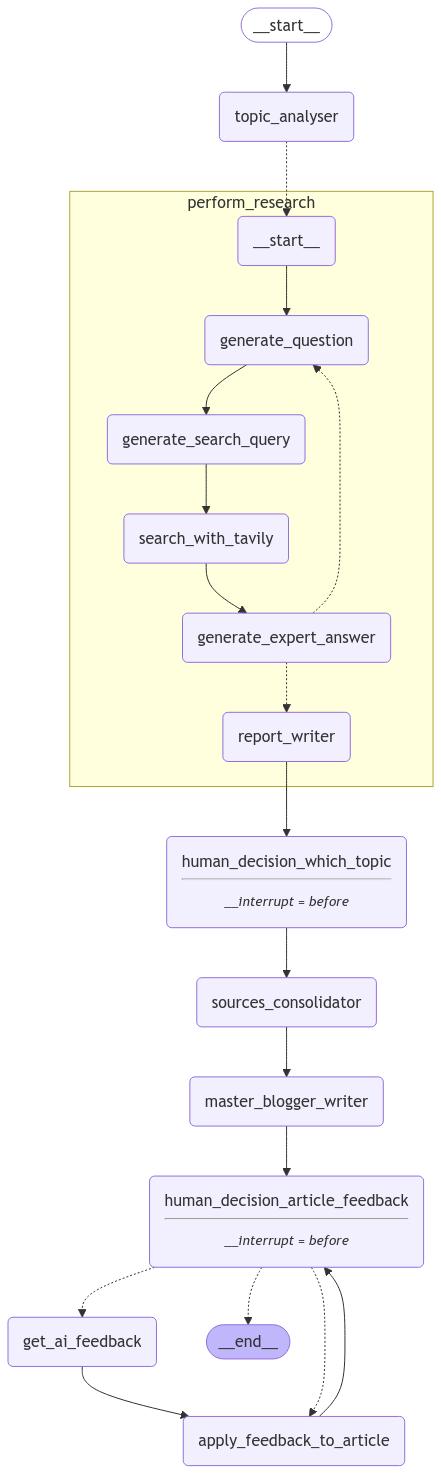

In [93]:
graph = builder.compile(interrupt_before=["human_decision_which_topic", "human_decision_article_feedback"],
                        checkpointer=memory)
    
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
# with sqlite3.connect("./data/streameye_context_data/conn_db.sqlite") as conn:
#     memory = SqliteSaver(conn)
#     graph = builder.compile(interrupt_before=["human_decision_which_topic", "human_decision_article_feedback"],checkpointer=memory)
    

In [74]:
company_profile = {
    "name": "StreamEye LTD",
    "description": """
        Streameye is the creative management platform for fast-moving brands that allows you 
        to mass-produce creatives in a manner of minutes.
    """
}
articles, usps = company_context_builder("./data/streameye_context_data/articles/", 
                            './data/streameye_context_data/articles/articles.json',
                            './data/streameye_context_data/usps/')
thread = {"configurable": {"thread_id": 1003}}



In [37]:
recovered_state = await graph.aget_state(config=thread)
recovered_history = [state async for state in graph.aget_state_history(config=thread)]

In [38]:
selected_report = recovered_state.values.get("selected_report")

In [39]:
documents = "\n\n---\n\n".join(selected_report["context"]).split("\n\n---\n\n")


links = [find_doc_source(document) for document in documents]
used_links = [link for link in links if selected_report["conversation"].find(link) > -1]
used_links

['https://wisernotify.com/blog/omnichannel-stats/',
 'https://www.salesgenie.com/blog/35-must-know-multichannel-marketing-statistics-for-2025/',
 'https://www.arielsoftwares.com/ai-and-cloud-solutions-digital-transformation-automation/',
 'https://www.businesswire.com/news/home/20240701079039/en/o9-Enhances-Its-Digital-Brain-Platform-With-Generative-AI-Powered-Composite-Agents-to-Execute-Complex-Cross-Functional-Planning']

In [40]:
recovered_history[0].next

('sources_consolidator',)

In [41]:
# recovered_history[0].next
# continue from a point:
async for event in graph.astream(None, config=recovered_history[0].config, stream_mode="updates"):
    print(event)

0 4
appending.. https://wisernotify.com/blog/omnichannel-stats/
1 4
appending.. https://www.salesgenie.com/blog/35-must-know-multichannel-marketing-statistics-for-2025/
2 4
appending.. https://www.arielsoftwares.com/ai-and-cloud-solutions-digital-transformation-automation/
3 4
Skipping a page due to timeout.
PAGE IS skipped, continuing
Summarising...
summarised content
Trimmed and ready
Trimmed and ready
{'sources_consolidator': {'final_documents': '<Document href="https://wisernotify.com/blog/omnichannel-stats/" title="45 Omnichannel Statistics & Trends (New 2025 Data)" description="Omnichannel statistics show that using omnichannel marketing can increase sales by 287%. Want to learn more? This is the place for you!"/>\n            \nHere is a summary of the document in up to 1500 words, keeping important points and structure:\n\n**Introduction**\n\nThe document provides an overview of omnichannel statistics and trends for 2025. Omnichannel strategies are becoming increasingly popular

In [75]:
async for event in graph.astream({"goal": "position Streameye as a platform with enterprise level support and customisation for production of digital assets at scale",
                       "company_profile": company_profile,
                       "max_questions": 2,
                       "previous_articles": articles,
                       "usps": usps
                      }, config=thread, stream_mode="updates"):
    print(event)

{'topic_analyser': {'goal': 'position Streameye as a platform with enterprise level support and customisation for production of digital assets at scale', 'company_profile': {'name': 'StreamEye LTD', 'description': '\n        Streameye is the creative management platform for fast-moving brands that allows you \n        to mass-produce creatives in a manner of minutes.\n    '}, 'previous_articles': [{'title': 'Digital_Advertising_Trends_In_2023', 'content': "With 2023 already underway, the digital advertising landscape is already paving the way for new trends that are expected to stick around for a long time. As a marketer, it's imperative to stay up-to-date with the latest trends to ensure that your ads are effective and engaging. This article highlights the most important guidelines that will shape the next phase of effective advertising.\n\nBefore jumping in, make sure to check out our portfolio of [successful HTML5 ad campaigns](/showcase).\n  \n\n## Digital Advertising: Top 6 trends

In [87]:
await memory_cm.__aexit__(None, None, None)

False

In [32]:
# sync
for event in graph.stream({"goal": "present Streameye as a reliable partner for process optimisation, comparing it to regular asset delivery processes",
                       "company_profile": company_profile,
                       "max_questions": 2,
                       "previous_articles": articles,
                       "usps": usps
                      }, config=thread, stream_mode="updates"):
    print(event)

ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 129921285633472 and this is thread id 129920317507264.

### Selecting the report

Below is code snippet for selecting the report index as `selected_report`

In [76]:
current_state = await graph.aget_state(config=thread)
reports = current_state.values["reports"]

if len(reports) == 0:
    raise ValueError("Reports are not generated, rerun the App!")

for i, report in enumerate(reports):
    print(f"{i}. Title: {report["title"]}\n\nHere is the plan:\n{report["report_plan"]}\n\nChoose index to select report")
valid_choices = [str(i) for i in range(len(reports))]
indexes = ', '.join(valid_choices)

invalid = True
while invalid:
    chosen = input(f"Select from: {indexes} => ")
    if chosen in valid_choices:
        invalid = False
    else:
        print("Select form valid indexes")


#     if len(reports) == 0:
#         raise ValueError("Reports are not generated, rerun the App!")

#     for i, report in enumerate(reports):
#         print(f"{i}. Title: {report.title}\n\nHere is the plan:\n{report.report_plan}\n\nChoose index to select report")
#     valid_choices = [str(i) for i in range(len(reports))]
#     indexes = ', '.join(valid_choices)
#     invalid = True
#     while invalid:
#         chosen = input(f"Select from: {indexes} => ")
#         if chosen in valid_choices:
#             invalid = False
#         else:
#             print("Select form valid indexes")
    
#     return {"selected_report": reports[chosen]}

0. Title: Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality

Here is the plan:
Here is a conspect of the conversation between Suzan (copywriter) and AI (marketing expert):

**Summary:**

The conversation revolves around the topic of "Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality". The marketing expert explains that mass-producing digital assets refers to efficiently creating and distributing a high volume of content in various formats and sizes for different channels and platforms. Common pain points faced by enterprise brands include time-consuming manual processes, lack of resources, inconsistent branding, and difficulty in scaling creative work.

The expert highlights Streameye's platform as a solution that addresses these challenges through automation, customization, and collaboration features. The platform enables users to automate repetitive tasks, create custom templates a

Select from: 0, 1 =>  0


In [77]:
state_config = current_state.config

updated_state = await graph.aupdate_state(
            state_config,
            {"selected_report": reports[int(chosen)] },
            as_node="human_decision_which_topic"
        )


In [78]:
history =  [state async for state in graph.aget_state_history(config=thread)]

In [79]:
len(history)

5

In [80]:
history[3].values.get("search_query")

In [81]:
async for event in graph.astream(None, config=thread, stream_mode="updates"):
    print(event)

0 4
appending.. https://openasset.com/blog/common-challenges-in-dam/
1 4
appending.. https://imagekit.io/blog/everything-you-need-to-know-about-brand-assets/
2 4
appending.. https://www.streameye.com/features
3 4
appending.. https://www.streameye.com/case-studies
Summarising...
summarised content
Summarising...
summarised content
Trimmed and ready
Trimmed and ready
{'sources_consolidator': {'final_documents': '<Document href="https://openasset.com/blog/common-challenges-in-dam/" title="How to Overcome Common Challenges in Digital Asset Management - OpenAsset" description="Learn some of the common challenges faced in DAM, and how these challenges can be solved so you\'re confident and prepared for implementation."/>\n            \nHere is a summary of the document in up to 1500 words:\n\n**Introduction**\n\nDigital Asset Management (DAM) has become an essential tool for organizations to manage and control their digital assets. However, implementing and using a DAM system can be challeng

### Provide Feedback or Choose END | AI

Below is the code to provide user feedback, select AI to generate AI based feedback or END the graph

In [179]:
# history = [state for state in graph.get_state_history(config=thread)]
# for h in history:
#     print([key for key in h.metadata.keys()])

['source', 'writes', 'thread_id', 'checkpoint_ns', 'checkpoint_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'checkpoint_ns', 'checkpoint_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'checkpoint_ns', 'checkpoint_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'step', 'parents', 'checkpoint_ns', 'checkpoint_id']
['source', 'writes', 'thread_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'step', 'parents']
['source', 'writes', 'thread_id', 'step', 'parents']


In [82]:
history_1 = [step async for step in graph.aget_state_history(thread)] # lets store these on the first go!

len(history_1)

7

In [103]:
current_state = await graph.aget_state(thread)
current_state_config = current_state.config
article = current_state.values["final_article"]


display(Markdown(f"Here is the article \n\n{article}"))
print(f"""Previous feedback by AI if any:{current_state.values.get("ai_article_feedback", '')},
Your feedback: {current_state.values.get('human_article_feedback', '')}""")
choice = input("Type in your input [feedback | AI | END]")
new_state = {}
if not choice or choice == 'END': # we fallback to end the graph if no choice
    new_state = await graph.aupdate_state(current_state_config, {"human_article_feedback": "END"}, as_node="human_decision_article_feedback")
else:
    new_state = await graph.aupdate_state(current_state_config, {"human_article_feedback": choice}, as_node="human_decision_article_feedback")
    


Here is the article 

```markdown
# Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality

In today's fast-paced digital landscape, enterprise brands are under constant pressure to produce high-quality digital assets at scale. A staggering 70% of marketers report that creating content is their biggest challenge, highlighting the need for efficient solutions. Whether it's creating multiple versions of images for different social media platforms or generating unique videos for marketing campaigns, the demand for efficient and consistent content creation has never been higher. However, achieving this without compromising on quality can be a daunting task.

This article explores how enterprise brands can overcome these challenges by leveraging advanced tools like StreamEye, which not only streamlines the production process but also ensures that creativity and quality remain at the forefront.

## The Challenge of Mass-Producing Digital Assets

Before diving into solutions, it's essential to understand what mass-producing digital assets entails. According to marketing experts, this refers to efficiently creating and distributing a high volume of content in various formats and sizes for different channels and platforms [1]. This can include resizing images for social media or email marketing, as well as producing unique assets like short-form videos for TikTok or Instagram Reels.

Enterprise brands often face several pain points when trying to produce digital assets at scale:

- **Time-Consuming Manual Processes**: Manually creating and editing each asset is labor-intensive and time-consuming. As one industry expert noted, "The manual process can drain resources and slow down campaigns."
- **Lack of Resources**: Small teams or limited budgets can hinder the production of high-quality content at the required volume.
- **Inconsistent Branding**: Without a centralized system, maintaining brand consistency across all channels becomes challenging [2].
- **Difficulty in Scaling Creative Work**: As businesses grow, their creative needs expand, but internal teams may not be equipped to handle increased demand.

These challenges can lead to delayed campaigns, reduced brand consistency, and decreased customer engagement. To address these issues effectively, brands need a robust solution that combines automation, customization, and seamless collaboration.

## StreamEye: A Solution for Enterprise Brands

StreamEye emerges as a powerful platform designed specifically to meet the needs of enterprise brands looking to scale their digital asset production while maintaining quality. By integrating automation, customization, and collaboration features, StreamEye offers a comprehensive solution to the challenges faced by marketers.

### Automation Capabilities

One of the standout features of StreamEye is its automation capabilities. The platform allows users to automate repetitive tasks such as resizing images or generating social media posts. This not only saves time but also frees up creative teams to focus on more strategic and innovative work [3].

For instance, with StreamEye's automation tools, marketers can quickly generate multiple versions of an image for different platforms without manual intervention. This efficiency ensures that content is delivered on time while maintaining high standards.

### Customization Options

Customization is another area where StreamEye excels. The platform provides users with the ability to create custom templates and workflows tailored to their specific needs. Whether it's designing a unique layout for social media posts or setting up a workflow for video production, StreamEye ensures that every asset produced aligns perfectly with brand guidelines.

This level of customization not only enhances consistency but also allows brands to adapt quickly to changing market demands. By having control over templates and workflows, teams can iterate rapidly on new offers and campaigns without compromising on quality. This aligns with StreamEye's unique proposition of "Own Your Brand."

### Collaboration Benefits

Effective collaboration is crucial for any successful marketing team. StreamEye facilitates seamless teamwork by allowing multiple stakeholders to review and approve content in real-time. This feature reduces the risk of errors and miscommunication, ensuring that everyone is aligned with the brand's vision [3].

For example, a marketing team can collaborate on a video project where different members handle scriptwriting, design, and editing. StreamEye's collaborative platform ensures that all changes are tracked, feedback is incorporated efficiently, and the final product meets high-quality standards. This adaptability reflects StreamEye's commitment to being a "Platform That Follows You."

## A Real-World Success Story: LiveScore

To illustrate how StreamEye makes a difference, let's look at the case of LiveScore, a leading sports media company. LiveScore uses StreamEye to produce high-volume, high-quality digital assets for their global audience. With StreamEye, they automate the creation of social media posts, resize images for different channels, and ensure brand consistency across all content [4].

This partnership has enabled LiveScore to streamline their production process, reduce manual errors, and deliver engaging content on time. Notably, LiveScore reported a 30% increase in content output and a 25% reduction in production time after implementing StreamEye. Their success story highlights how StreamEye can transform an organization's digital asset production capabilities.

## Ensuring Quality Control

Maintaining quality is paramount in any digital asset production process. StreamEye addresses this through its Approvals feature, which enforces teams to publish only approved content by a designated party within the organization. This ensures that all assets meet the required standards before publication, particularly crucial for regulated markets [3].

By integrating quality control into the workflow, StreamEye helps brands maintain their reputation and deliver consistent experiences to their audience. This feature is especially beneficial for industries where compliance is critical, ensuring that all marketing materials adhere to necessary regulations.

## Conclusion: Elevate Your Digital Asset Production

In conclusion, mass-producing digital assets at scale is no longer a challenge but an opportunity for enterprise brands. With the right tools like StreamEye, brands can automate repetitive tasks, customize workflows, collaborate seamlessly, and ensure quality control throughout the production process.

If you're ready to transform your digital asset production and elevate your marketing efforts, it's time to explore how StreamEye can be your partner in scaling creativity without sacrificing quality. **[Book a demo](https://www.streameye.com/contact)** today and receive a personalized consultation to see firsthand how StreamEye can revolutionize your approach to digital assets.

---

**References:**

[1] https://openasset.com/blog/common-challenges-in-dam/

[2] https://imagekit.io/blog/everything-you-need-to-know-about-brand-assets/

[3] https://www.streameye.com/features

[4] https://www.streameye.com/case-studies
```

Previous feedback by AI if any:- **Introduction Enhancement**: The introduction effectively sets the stage but could benefit from a more engaging hook. Consider starting with a compelling statistic or a brief anecdote about a brand that struggled with digital asset production before finding a solution.

- **Pain Points Expansion**: While the pain points are well-articulated, adding more specific examples or quotes from industry experts could enhance credibility and relatability. This would also help in connecting with the reader's own experiences.

- **USP Integration**: Ensure that the company's USPs are more explicitly woven into the narrative. For instance, emphasize "Own Your Brand" when discussing customization and brand consistency, and "Platform That Follows You" when talking about adaptability and enterprise support.

- **Use Case Detail**: The LiveScore example is a strong addition, but it could be more impactful with additional details. Include specific metrics or outcomes th

Type in your input [feedback | AI | END] END


In [84]:
await graph.aupdate_state(current_state_config, {"human_article_feedback": choice}, as_node="human_decision_article_feedback")

{'configurable': {'thread_id': '1003',
  'checkpoint_ns': '',
  'checkpoint_id': '1efefabf-d806-6e8e-8006-01cc353f6e8b'}}

In [79]:
r = open_ai_llm.invoke([HumanMessage("Hi there")])

In [81]:
r.content

'Hello! How can I assist you today?'

In [85]:
async for event in graph.astream(None, config=thread, stream_mode="updates"):
    print(event)

RESULT content='- **Introduction Enhancement**: The introduction effectively sets the stage but could benefit from a more engaging hook. Consider starting with a compelling statistic or a brief anecdote about a brand that struggled with digital asset production before finding a solution.\n\n- **Pain Points Expansion**: While the pain points are well-articulated, adding more specific examples or quotes from industry experts could enhance credibility and relatability. This would also help in connecting with the reader\'s own experiences.\n\n- **USP Integration**: Ensure that the company\'s USPs are more explicitly woven into the narrative. For instance, emphasize "Own Your Brand" when discussing customization and brand consistency, and "Platform That Follows You" when talking about adaptability and enterprise support.\n\n- **Use Case Detail**: The LiveScore example is a strong addition, but it could be more impactful with additional details. Include specific metrics or outcomes that demo

In [104]:
final_state = await graph.aget_state(thread)
article = final_state.values.get("final_article")

'```markdown\n# Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality\n\nIn today\'s fast-paced digital landscape, enterprise brands are under constant pressure to produce high-quality digital assets at scale. A staggering 70% of marketers report that creating content is their biggest challenge, highlighting the need for efficient solutions. Whether it\'s creating multiple versions of images for different social media platforms or generating unique videos for marketing campaigns, the demand for efficient and consistent content creation has never been higher. However, achieving this without compromising on quality can be a daunting task.\n\nThis article explores how enterprise brands can overcome these challenges by leveraging advanced tools like StreamEye, which not only streamlines the production process but also ensures that creativity and quality remain at the forefront.\n\n## The Challenge of Mass-Producing Digital Assets\n\nBefore di

In [107]:
final_history = [state async for state in graph.aget_state_history(config=thread)]

In [108]:
len(final_history)

14

In [101]:
final_history[2].next

('apply_feedback_to_article',)

In [102]:
#try and reaply the article feedback with the smaller model but bigger context...
async for event in graph.astream(None, config=final_history[2].config, stream_mode="updates"):
    print(event)

{'apply_feedback_to_article': {'final_article': '```markdown\n# Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality\n\nIn today\'s fast-paced digital landscape, enterprise brands are under constant pressure to produce high-quality digital assets at scale. A staggering 70% of marketers report that creating content is their biggest challenge, highlighting the need for efficient solutions. Whether it\'s creating multiple versions of images for different social media platforms or generating unique videos for marketing campaigns, the demand for efficient and consistent content creation has never been higher. However, achieving this without compromising on quality can be a daunting task.\n\nThis article explores how enterprise brands can overcome these challenges by leveraging advanced tools like StreamEye, which not only streamlines the production process but also ensures that creativity and quality remain at the forefront.\n\n## The Challen

In [99]:
final_state.values.get("final_article")

"# Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality\n\nIn today's fast-paced digital landscape, enterprise brands are under constant pressure to produce high-quality digital assets at scale. Whether it's creating multiple versions of images for different social media platforms or generating unique videos for marketing campaigns, the demand for efficient and consistent content creation has never been higher. However, achieving this without compromising on quality can be a daunting task.\n\nThis article explores how enterprise brands can overcome these challenges by leveraging advanced tools like StreamEye, which not only streamlines the production process but also ensures that creativity and quality remain at the forefront.\n\n## The Challenge of Mass-Producing Digital Assets\n\nBefore diving into solutions, it's essential to understand what mass-producing digital assets entails. According to marketing experts, this refers to efficien

In [67]:
for step in final_history:
    print(step.values.get("search_query"))

None
None
None
None
None
None
None
None
None
None
None
None


In [106]:
display(Markdown(article))

with open('./data/streameye_context_data/2.md', 'w') as f:
    f.write(article)

```markdown
# Scaling Creativity: How Enterprise Brands Can Mass-Produce Digital Assets Without Sacrificing Quality

In today's fast-paced digital landscape, enterprise brands are under constant pressure to produce high-quality digital assets at scale. A staggering 70% of marketers report that creating content is their biggest challenge, highlighting the need for efficient solutions. Whether it's creating multiple versions of images for different social media platforms or generating unique videos for marketing campaigns, the demand for efficient and consistent content creation has never been higher. However, achieving this without compromising on quality can be a daunting task.

This article explores how enterprise brands can overcome these challenges by leveraging advanced tools like StreamEye, which not only streamlines the production process but also ensures that creativity and quality remain at the forefront.

## The Challenge of Mass-Producing Digital Assets

Before diving into solutions, it's essential to understand what mass-producing digital assets entails. According to marketing experts, this refers to efficiently creating and distributing a high volume of content in various formats and sizes for different channels and platforms [1]. This can include resizing images for social media or email marketing, as well as producing unique assets like short-form videos for TikTok or Instagram Reels.

Enterprise brands often face several pain points when trying to produce digital assets at scale:

- **Time-Consuming Manual Processes**: Manually creating and editing each asset is labor-intensive and time-consuming. As one industry expert noted, "The manual process can drain resources and slow down campaigns."
- **Lack of Resources**: Small teams or limited budgets can hinder the production of high-quality content at the required volume.
- **Inconsistent Branding**: Without a centralized system, maintaining brand consistency across all channels becomes challenging [2].
- **Difficulty in Scaling Creative Work**: As businesses grow, their creative needs expand, but internal teams may not be equipped to handle increased demand.

These challenges can lead to delayed campaigns, reduced brand consistency, and decreased customer engagement. To address these issues effectively, brands need a robust solution that combines automation, customization, and seamless collaboration.

## StreamEye: A Solution for Enterprise Brands

StreamEye emerges as a powerful platform designed specifically to meet the needs of enterprise brands looking to scale their digital asset production while maintaining quality. By integrating automation, customization, and collaboration features, StreamEye offers a comprehensive solution to the challenges faced by marketers.

### Automation Capabilities

One of the standout features of StreamEye is its automation capabilities. The platform allows users to automate repetitive tasks such as resizing images or generating social media posts. This not only saves time but also frees up creative teams to focus on more strategic and innovative work [3].

For instance, with StreamEye's automation tools, marketers can quickly generate multiple versions of an image for different platforms without manual intervention. This efficiency ensures that content is delivered on time while maintaining high standards.

### Customization Options

Customization is another area where StreamEye excels. The platform provides users with the ability to create custom templates and workflows tailored to their specific needs. Whether it's designing a unique layout for social media posts or setting up a workflow for video production, StreamEye ensures that every asset produced aligns perfectly with brand guidelines.

This level of customization not only enhances consistency but also allows brands to adapt quickly to changing market demands. By having control over templates and workflows, teams can iterate rapidly on new offers and campaigns without compromising on quality. This aligns with StreamEye's unique proposition of "Own Your Brand."

### Collaboration Benefits

Effective collaboration is crucial for any successful marketing team. StreamEye facilitates seamless teamwork by allowing multiple stakeholders to review and approve content in real-time. This feature reduces the risk of errors and miscommunication, ensuring that everyone is aligned with the brand's vision [3].

For example, a marketing team can collaborate on a video project where different members handle scriptwriting, design, and editing. StreamEye's collaborative platform ensures that all changes are tracked, feedback is incorporated efficiently, and the final product meets high-quality standards. This adaptability reflects StreamEye's commitment to being a "Platform That Follows You."

## A Real-World Success Story: LiveScore

To illustrate how StreamEye makes a difference, let's look at the case of LiveScore, a leading sports media company. LiveScore uses StreamEye to produce high-volume, high-quality digital assets for their global audience. With StreamEye, they automate the creation of social media posts, resize images for different channels, and ensure brand consistency across all content [4].

This partnership has enabled LiveScore to streamline their production process, reduce manual errors, and deliver engaging content on time. Notably, LiveScore reported a 30% increase in content output and a 25% reduction in production time after implementing StreamEye. Their success story highlights how StreamEye can transform an organization's digital asset production capabilities.

## Ensuring Quality Control

Maintaining quality is paramount in any digital asset production process. StreamEye addresses this through its Approvals feature, which enforces teams to publish only approved content by a designated party within the organization. This ensures that all assets meet the required standards before publication, particularly crucial for regulated markets [3].

By integrating quality control into the workflow, StreamEye helps brands maintain their reputation and deliver consistent experiences to their audience. This feature is especially beneficial for industries where compliance is critical, ensuring that all marketing materials adhere to necessary regulations.

## Conclusion: Elevate Your Digital Asset Production

In conclusion, mass-producing digital assets at scale is no longer a challenge but an opportunity for enterprise brands. With the right tools like StreamEye, brands can automate repetitive tasks, customize workflows, collaborate seamlessly, and ensure quality control throughout the production process.

If you're ready to transform your digital asset production and elevate your marketing efforts, it's time to explore how StreamEye can be your partner in scaling creativity without sacrificing quality. **[Book a demo](https://www.streameye.com/contact)** today and receive a personalized consultation to see firsthand how StreamEye can revolutionize your approach to digital assets.

---

**References:**

[1] https://openasset.com/blog/common-challenges-in-dam/

[2] https://imagekit.io/blog/everything-you-need-to-know-about-brand-assets/

[3] https://www.streameye.com/features

[4] https://www.streameye.com/case-studies
```